<a href="https://colab.research.google.com/github/shuheimisawa/annotate_tpath/blob/main/02_preprocessing_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Setup and Configuration

In [5]:
# Cell 1: Authentication and Setup
from google.colab import auth
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Authenticate with Google Cloud
auth.authenticate_user()

# Core configuration
PROJECT_ID = "gen-lang-client-0716540381"
BUCKET_NAME = "project_tpath"
PROCESSING_BATCH_SIZE = 5

# Processing parameters
TILE_SIZE = 224
OVERLAP_THRESHOLD = 0.3
MIN_TISSUE_AREA = 1000

print("Authentication completed")
print("Preprocessing pipeline initialized")
print(f"Target tile size: {TILE_SIZE}x{TILE_SIZE}")
print(f"Processing batch size: {PROCESSING_BATCH_SIZE}")

Authentication completed
Preprocessing pipeline initialized
Target tile size: 224x224
Processing batch size: 5


Library Installation

In [6]:
# Cell 2: Install Required Libraries
!pip install -q openslide-python
!pip install -q shapely
!pip install -q opencv-python
!pip install -q scikit-image

# Import core libraries
import openslide
from shapely.geometry import Polygon, Point
import cv2
from skimage import filters, morphology, measure
from skimage.color import rgb2gray

print("Core libraries imported successfully")
print(f"OpenSlide version: {openslide.__version__}")

Core libraries imported successfully
OpenSlide version: 1.4.2


GCS Connection with Proper Authentication

In [7]:
# Cell 3: GCS Connection and File Operations
# Initialize GCS client
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(BUCKET_NAME)

def list_wsi_files(limit=None):
    """List WSI files in the bucket"""
    wsi_files = []
    blobs = bucket.list_blobs(prefix="raw_wsi/")

    for blob in blobs:
        if blob.name.endswith(('.svs', '.tiff', '.tif', '.ndpi')):
            wsi_files.append({
                'filename': blob.name.split('/')[-1],
                'base_name': Path(blob.name).stem,
                'blob_name': blob.name,
                'size_mb': blob.size / (1024 * 1024) if blob.size else 0
            })
            if limit and len(wsi_files) >= limit:
                break

    return wsi_files

def list_annotation_files():
    """List annotation files in the bucket"""
    annotation_files = []
    blobs = bucket.list_blobs(prefix="qupath_annotations/")

    for blob in blobs:
        if blob.name.endswith('.geojson'):
            annotation_files.append({
                'filename': blob.name.split('/')[-1],
                'base_name': blob.name.split('/')[-1].replace('.geojson', ''),
                'blob_name': blob.name
            })

    return annotation_files

# Test the connection
wsi_files = list_wsi_files(limit=5)
annotation_files = list_annotation_files()

print(f"Found {len(wsi_files)} WSI files (showing first 5)")
for f in wsi_files:
    print(f"  {f['filename']} ({f['size_mb']:.1f} MB)")

print(f"\nFound {len(annotation_files)} annotation files")
for f in annotation_files:
    print(f"  {f['filename']}")

Found 5 WSI files (showing first 5)
  TPATH001.svs (318.7 MB)
  TPATH002.svs (243.0 MB)
  TPATH003.svs (216.9 MB)
  TPATH004.svs (128.2 MB)
  TPATH005.svs (209.6 MB)

Found 2 annotation files
  TPATH001.geojson
  TPATH002.geojson


Slide Metadata Extraction

In [8]:
# Cell 4: Simple Slide Metadata Extraction
def download_and_open_slide(blob_name, temp_path="/tmp/"):
    """Download slide from GCS and open with OpenSlide"""
    slide = None
    local_path = None

    try:
        # Create temp filename
        filename = blob_name.split('/')[-1]
        local_path = os.path.join(temp_path, filename)

        # Download file
        print(f"Downloading {filename}...")
        blob = bucket.blob(blob_name)
        blob.download_to_filename(local_path)
        print(f"Downloaded to {local_path}")

        # Open with OpenSlide
        slide = openslide.OpenSlide(local_path)
        print(f"Slide opened successfully")

        return slide, local_path
    except Exception as e:
        print(f"Error opening slide {blob_name}: {str(e)}")
        if local_path and os.path.exists(local_path):
            os.remove(local_path)
        return None, None

def extract_slide_metadata(slide, slide_name):
    """Extract basic metadata from slide"""
    if slide is None:
        return None

    try:
        metadata = {
            'slide_name': slide_name,
            'dimensions': slide.dimensions,
            'level_count': slide.level_count,
            'level_dimensions': slide.level_dimensions,
            'level_downsamples': slide.level_downsamples,
            'properties': dict(slide.properties)
        }

        # Extract key properties safely
        metadata['vendor'] = slide.properties.get('openslide.vendor', 'unknown')
        metadata['magnification'] = slide.properties.get('openslide.objective-power', 'unknown')

        return metadata
    except Exception as e:
        print(f"Error extracting metadata for {slide_name}: {str(e)}")
        return None

# Test with first available slide (only if we have WSI files)
if 'wsi_files' in locals() and wsi_files:
    test_slide_info = wsi_files[0]
    print(f"\nTesting metadata extraction with: {test_slide_info['filename']}")

    slide, local_path = download_and_open_slide(test_slide_info['blob_name'])
    if slide:
        metadata = extract_slide_metadata(slide, test_slide_info['base_name'])
        if metadata:
            print("Metadata extraction successful!")
            print(f"  Dimensions: {metadata['dimensions']}")
            print(f"  Levels: {metadata['level_count']}")
            print(f"  Vendor: {metadata['vendor']}")
            print(f"  Magnification: {metadata['magnification']}")

        # Cleanup
        slide.close()
        if local_path and os.path.exists(local_path):
            os.remove(local_path)
            print("Temporary file cleaned up")
    else:
        print("Failed to open slide")
else:
    print("No WSI files available for testing")


Testing metadata extraction with: TPATH001.svs
Downloaded to /tmp/TPATH001.svs
Slide opened successfully
Metadata extraction successful!
  Dimensions: (81920, 45056)
  Levels: 3
  Vendor: aperio
  Magnification: 20
Temporary file cleaned up


Annotation Processing Setup

In [9]:
# Cell 5: Annotation Processing Setup
from shapely.geometry import Polygon, Point
from shapely.validation import make_valid
import json

def download_annotation_file(blob_name):
    """Download and parse QuPath GeoJSON annotation file"""
    try:
        blob = bucket.blob(blob_name)
        content = blob.download_as_text()
        data = json.loads(content)
        return data
    except Exception as e:
        print(f"Error downloading annotation {blob_name}: {str(e)}")
        return None

def parse_annotations(geojson_data, slide_name):
    """Parse GeoJSON annotations into structured format"""
    if not geojson_data or 'features' not in geojson_data:
        return []

    annotations = []

    for i, feature in enumerate(geojson_data['features']):
        try:
            # Extract geometry
            geometry = feature.get('geometry', {})
            if geometry.get('type') != 'Polygon':
                continue

            coordinates = geometry.get('coordinates', [])
            if not coordinates or len(coordinates[0]) < 3:
                continue

            # Create polygon
            polygon_coords = coordinates[0]  # Exterior ring
            polygon = Polygon(polygon_coords)

            # Validate and fix if needed
            if not polygon.is_valid:
                polygon = make_valid(polygon)

            # Extract properties
            properties = feature.get('properties', {})
            classification = properties.get('classification', {})
            class_name = classification.get('name', 'Unknown')

            # Calculate basic metrics
            bounds = polygon.bounds
            area = polygon.area
            centroid = polygon.centroid

            annotation = {
                'id': i,
                'slide_name': slide_name,
                'polygon': polygon,
                'class_name': class_name,
                'area': area,
                'bounds': bounds,  # (minx, miny, maxx, maxy)
                'centroid': (centroid.x, centroid.y),
                'vertex_count': len(polygon_coords)
            }

            annotations.append(annotation)

        except Exception as e:
            print(f"Error parsing annotation {i} in {slide_name}: {str(e)}")
            continue

    return annotations

# Test annotation processing with available files
if annotation_files:
    test_annotation = annotation_files[0]
    print(f"Testing annotation processing with: {test_annotation['filename']}")

    geojson_data = download_annotation_file(test_annotation['blob_name'])
    if geojson_data:
        annotations = parse_annotations(geojson_data, test_annotation['base_name'])
        print(f"Successfully parsed {len(annotations)} annotations")

        if annotations:
            # Show sample annotation
            sample = annotations[0]
            print(f"Sample annotation:")
            print(f"  Class: {sample['class_name']}")
            print(f"  Area: {sample['area']:.1f}")
            print(f"  Vertices: {sample['vertex_count']}")
            print(f"  Centroid: ({sample['centroid'][0]:.1f}, {sample['centroid'][1]:.1f})")
    else:
        print("Failed to download annotation file")
else:
    print("No annotation files available for testing")

Testing annotation processing with: TPATH001.geojson
Successfully parsed 187 annotations
Sample annotation:
  Class: Normal
  Area: 73586.0
  Vertices: 730
  Centroid: (17574.0, 13179.8)


Tissue Detection

In [22]:
# Cell 13: Enhanced Tissue Detection (Replaces Cell 6)
def create_tissue_mask(slide, level=2, tissue_threshold=0.9):
    """Create tissue mask with optimized thresholds for kidney tissue"""
    try:
        # Get thumbnail at specified level
        thumbnail = slide.read_region((0, 0), level, slide.level_dimensions[level])
        thumbnail = thumbnail.convert('RGB')
        thumbnail_array = np.array(thumbnail)

        # Convert to grayscale
        gray = rgb2gray(thumbnail_array)

        # Optimized thresholding for kidney tissue
        threshold = filters.threshold_otsu(gray)
        binary = gray < threshold * tissue_threshold  # More permissive

        # Gentler morphological operations
        binary = morphology.remove_small_objects(binary, min_size=50)
        binary = morphology.binary_closing(binary, morphology.disk(2))

        return binary, thumbnail_array

    except Exception as e:
        print(f"Error creating tissue mask: {str(e)}")
        return None, None

def check_annotation_tissue_overlap(annotation, tissue_mask, transform_info, min_overlap=20):
    """Check tissue overlap with kidney-optimized thresholds"""
    try:
        # Transform annotation to tissue mask level
        transformed_ann = transform_annotation_coords(annotation, transform_info)

        # Get polygon bounds
        minx, miny, maxx, maxy = transformed_ann['bounds']

        # Ensure bounds are within mask dimensions
        mask_h, mask_w = tissue_mask.shape
        minx = max(0, int(minx))
        miny = max(0, int(miny))
        maxx = min(mask_w, int(maxx))
        maxy = min(mask_h, int(maxy))

        # Check if bounds are valid
        if minx >= maxx or miny >= maxy:
            return {'overlap_percentage': 0, 'has_tissue': False, 'reason': 'Invalid bounds'}

        # Extract region from tissue mask
        mask_region = tissue_mask[miny:maxy, minx:maxx]

        # Calculate overlap
        tissue_pixels_in_region = np.sum(mask_region)
        total_pixels_in_region = mask_region.size

        overlap_percentage = (tissue_pixels_in_region / total_pixels_in_region * 100) if total_pixels_in_region > 0 else 0

        # Kidney-optimized threshold (20% minimum tissue overlap)
        has_tissue = overlap_percentage > min_overlap

        return {
            'overlap_percentage': overlap_percentage,
            'has_tissue': has_tissue,
            'tissue_pixels': tissue_pixels_in_region,
            'total_pixels': total_pixels_in_region
        }

    except Exception as e:
        print(f"Error checking annotation-tissue overlap: {str(e)}")
        return {'overlap_percentage': 0, 'has_tissue': False}

print("Enhanced tissue detection ready (kidney-optimized)")
print("Optimizations:")
print("  - Tissue threshold: 0.9 (more permissive)")
print("  - Minimum overlap: 20% (vs 50%)")
print("  - Gentler morphological filtering")

Enhanced tissue detection ready (kidney-optimized)
Optimizations:
  - Tissue threshold: 0.9 (more permissive)
  - Minimum overlap: 20% (vs 50%)
  - Gentler morphological filtering


Coordinate System Conversion

In [11]:
# Cell 7: Coordinate System Conversion
def get_coordinate_transform(slide, target_level=0):
    """Get transformation parameters between annotation and slide coordinates"""
    try:
        # Annotation coordinates are typically at level 0 (highest resolution)
        # We need to transform them to other levels if needed

        level_0_dims = slide.level_dimensions[0]
        target_dims = slide.level_dimensions[target_level]
        downsample = slide.level_downsamples[target_level]

        transform = {
            'level_0_dims': level_0_dims,
            'target_level': target_level,
            'target_dims': target_dims,
            'downsample_factor': downsample,
            'scale_x': level_0_dims[0] / target_dims[0],
            'scale_y': level_0_dims[1] / target_dims[1]
        }

        return transform

    except Exception as e:
        print(f"Error creating coordinate transform: {str(e)}")
        return None

def transform_annotation_coords(annotation, transform_info):
    """Transform annotation coordinates to target level"""
    try:
        if transform_info is None:
            return annotation

        scale_x = transform_info['scale_x']
        scale_y = transform_info['scale_y']

        # Transform polygon coordinates
        original_coords = list(annotation['polygon'].exterior.coords)
        transformed_coords = [(x/scale_x, y/scale_y) for x, y in original_coords]

        # Create new polygon
        transformed_polygon = Polygon(transformed_coords)

        # Update annotation
        transformed_annotation = annotation.copy()
        transformed_annotation['polygon'] = transformed_polygon
        transformed_annotation['area'] = transformed_polygon.area
        transformed_annotation['bounds'] = transformed_polygon.bounds

        centroid = transformed_polygon.centroid
        transformed_annotation['centroid'] = (centroid.x, centroid.y)

        return transformed_annotation

    except Exception as e:
        print(f"Error transforming annotation coordinates: {str(e)}")
        return annotation

def check_annotation_tissue_overlap(annotation, tissue_mask, transform_info):
    """Check if annotation overlaps with tissue regions"""
    try:
        # Transform annotation to tissue mask level
        transformed_ann = transform_annotation_coords(annotation, transform_info)

        # Get polygon bounds
        minx, miny, maxx, maxy = transformed_ann['bounds']

        # Ensure bounds are within mask dimensions
        mask_h, mask_w = tissue_mask.shape
        minx = max(0, int(minx))
        miny = max(0, int(miny))
        maxx = min(mask_w, int(maxx))
        maxy = min(mask_h, int(maxy))

        # Extract region from tissue mask
        mask_region = tissue_mask[miny:maxy, minx:maxx]

        # Calculate overlap
        tissue_pixels_in_region = np.sum(mask_region)
        total_pixels_in_region = mask_region.size

        overlap_percentage = (tissue_pixels_in_region / total_pixels_in_region * 100) if total_pixels_in_region > 0 else 0

        return {
            'overlap_percentage': overlap_percentage,
            'has_tissue': overlap_percentage > 50,  # Threshold for valid annotation
            'tissue_pixels': tissue_pixels_in_region,
            'total_pixels': total_pixels_in_region
        }

    except Exception as e:
        print(f"Error checking annotation-tissue overlap: {str(e)}")
        return {'overlap_percentage': 0, 'has_tissue': False}

print("Coordinate transformation utilities ready")
print("Functions available:")
print("  - get_coordinate_transform()")
print("  - transform_annotation_coords()")
print("  - check_annotation_tissue_overlap()")

Coordinate transformation utilities ready
Functions available:
  - get_coordinate_transform()
  - transform_annotation_coords()
  - check_annotation_tissue_overlap()


Tile Extraction

Testing tile extraction...
Testing with matching pair: TPATH001.svs + TPATH001.geojson
Downloaded to /tmp/TPATH001.svs
Slide opened successfully
Tile extraction successful!
  Annotation class: Normal
  Tile coordinates: (17461, 13067)
  Tissue ratio: 0.69
  Valid tile: True


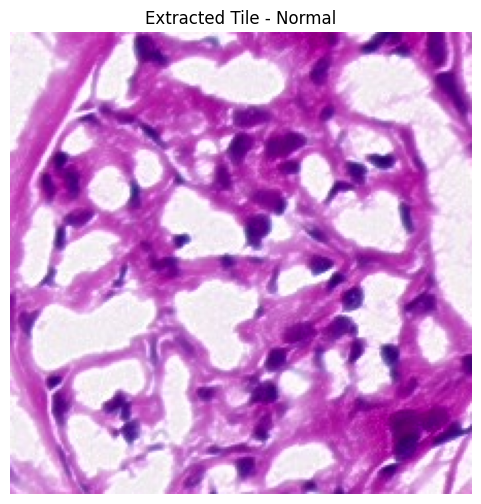

In [12]:
# Cell 8: Basic Tile Extraction
def extract_annotation_tile(slide, annotation, tile_size=224, level=0):
    """Extract tile centered on annotation"""
    try:
        # Get annotation centroid
        centroid_x, centroid_y = annotation['centroid']

        # Calculate tile boundaries
        half_tile = tile_size // 2

        # Tile coordinates at target level
        left = int(centroid_x - half_tile)
        top = int(centroid_y - half_tile)

        # Ensure coordinates are non-negative
        left = max(0, left)
        top = max(0, top)

        # Extract tile
        tile = slide.read_region((left, top), level, (tile_size, tile_size))
        tile = tile.convert('RGB')
        tile_array = np.array(tile)

        # Create tile info
        tile_info = {
            'slide_name': annotation['slide_name'],
            'annotation_id': annotation['id'],
            'class_name': annotation['class_name'],
            'coordinates': (left, top),
            'level': level,
            'size': (tile_size, tile_size),
            'tile_array': tile_array
        }

        return tile_info

    except Exception as e:
        print(f"Error extracting tile for annotation {annotation['id']}: {str(e)}")
        return None

def validate_tile_quality(tile_info, min_tissue_ratio=0.3):
    """Basic tile quality validation"""
    try:
        tile_array = tile_info['tile_array']

        # Convert to grayscale for analysis
        gray = rgb2gray(tile_array)

        # Simple tissue detection (not white background)
        tissue_mask = gray < 0.85  # Adjust threshold as needed
        tissue_ratio = np.sum(tissue_mask) / tissue_mask.size

        # Check for artifacts (very dark or very bright regions)
        mean_intensity = np.mean(gray)
        std_intensity = np.std(gray)

        quality_metrics = {
            'tissue_ratio': tissue_ratio,
            'mean_intensity': mean_intensity,
            'std_intensity': std_intensity,
            'is_valid': tissue_ratio > min_tissue_ratio and 0.1 < mean_intensity < 0.9
        }

        return quality_metrics

    except Exception as e:
        print(f"Error validating tile quality: {str(e)}")
        return {'is_valid': False}

# Test tile extraction
print("Testing tile extraction...")

# We need both slide and annotations for this test
if ('wsi_files' in locals() and wsi_files and
    'annotation_files' in locals() and annotation_files):

    # Find matching slide and annotation
    slide_info = None
    ann_info = None

    for slide in wsi_files:
        for ann in annotation_files:
            if slide['base_name'] == ann['base_name']:
                slide_info = slide
                ann_info = ann
                break
        if slide_info:
            break

    if slide_info and ann_info:
        print(f"Testing with matching pair: {slide_info['filename']} + {ann_info['filename']}")

        # Load slide and annotations
        slide_obj, local_path = download_and_open_slide(slide_info['blob_name'])
        geojson_data = download_annotation_file(ann_info['blob_name'])

        if slide_obj and geojson_data:
            annotations = parse_annotations(geojson_data, slide_info['base_name'])

            if annotations:
                # Extract tile from first annotation
                test_annotation = annotations[0]
                tile_info = extract_annotation_tile(slide_obj, test_annotation)

                if tile_info:
                    quality = validate_tile_quality(tile_info)

                    print("Tile extraction successful!")
                    print(f"  Annotation class: {tile_info['class_name']}")
                    print(f"  Tile coordinates: {tile_info['coordinates']}")
                    print(f"  Tissue ratio: {quality['tissue_ratio']:.2f}")
                    print(f"  Valid tile: {quality['is_valid']}")

                    # Show the extracted tile
                    plt.figure(figsize=(6, 6))
                    plt.imshow(tile_info['tile_array'])
                    plt.title(f"Extracted Tile - {tile_info['class_name']}")
                    plt.axis('off')
                    plt.show()

        # Cleanup
        if slide_obj:
            slide_obj.close()
        if local_path and os.path.exists(local_path):
            os.remove(local_path)
    else:
        print("No matching slide-annotation pairs found for testing")
else:
    print("Missing slide or annotation files for testing")

Multi-Resolution Tile Extraction Strategy

In [13]:
# Cell 9: Multi-Resolution Tile Extraction Strategy
def extract_multi_resolution_tiles(slide, annotation, levels=[0, 1], tile_sizes=[224, 448]):
    """Extract tiles at multiple resolutions for context"""
    tiles = {}

    try:
        centroid_x, centroid_y = annotation['centroid']

        for level, tile_size in zip(levels, tile_sizes):
            # Calculate downsample factor for this level
            downsample = slide.level_downsamples[level]

            # Adjust coordinates for level
            level_centroid_x = centroid_x / downsample
            level_centroid_y = centroid_y / downsample

            half_tile = tile_size // 2
            left = max(0, int(level_centroid_x - half_tile))
            top = max(0, int(level_centroid_y - half_tile))

            # Extract tile
            tile = slide.read_region((int(left * downsample), int(top * downsample)),
                                   level, (tile_size, tile_size))
            tile = tile.convert('RGB')

            tiles[f'level_{level}_{tile_size}'] = {
                'array': np.array(tile),
                'level': level,
                'size': tile_size,
                'coordinates': (left, top),
                'downsample': downsample
            }

        return tiles

    except Exception as e:
        print(f"Error extracting multi-resolution tiles: {str(e)}")
        return {}

print("Multi-resolution tile extraction ready")

Multi-resolution tile extraction ready


Batch Precessing Framework

In [15]:
# Cell 10: Batch Processing Framework
def process_slide_batch(slide_annotation_pairs, output_prefix="processed_data"):
    """Process a batch of slide-annotation pairs"""
    batch_results = []

    for i, (slide_info, ann_info) in enumerate(slide_annotation_pairs):
        print(f"\nProcessing {i+1}/{len(slide_annotation_pairs)}: {slide_info['filename']}")

        slide_result = {
            'slide_name': slide_info['base_name'],
            'slide_file': slide_info['filename'],
            'annotation_file': ann_info['filename'],
            'status': 'processing',
            'metadata': None,
            'annotations': [],
            'tissue_analysis': None,
            'processing_time': 0,
            'error_message': None
        }

        start_time = time.time()

        try:
            # Download and open slide
            slide, local_path = download_and_open_slide(slide_info['blob_name'])
            if not slide:
                slide_result['status'] = 'failed'
                slide_result['error_message'] = 'Failed to open slide'
                batch_results.append(slide_result)
                continue

            # Extract metadata
            metadata = extract_slide_metadata(slide, slide_info['base_name'])
            slide_result['metadata'] = metadata

            # Create tissue mask
            tissue_mask, thumbnail = create_tissue_mask(slide)
            if tissue_mask is not None:
                tissue_analysis = analyze_tissue_coverage(tissue_mask)
                slide_result['tissue_analysis'] = tissue_analysis

            # Process annotations
            geojson_data = download_annotation_file(ann_info['blob_name'])
            if geojson_data:
                annotations = parse_annotations(geojson_data, slide_info['base_name'])

                # Get coordinate transform for tissue mask level
                transform_info = get_coordinate_transform(slide, target_level=2)

                processed_annotations = []
                for ann in annotations:
                    # Check tissue overlap
                    if tissue_mask is not None and transform_info:
                        overlap_info = check_annotation_tissue_overlap(ann, tissue_mask, transform_info)
                        ann['tissue_overlap'] = overlap_info

                        # Only process annotations with good tissue overlap
                        if overlap_info['has_tissue']:
                            processed_annotations.append(ann)
                        else:
                            print(f"  Skipping annotation {ann['id']} - insufficient tissue overlap")
                    else:
                        processed_annotations.append(ann)

                slide_result['annotations'] = processed_annotations
                print(f"  Processed {len(processed_annotations)}/{len(annotations)} annotations")

            slide_result['status'] = 'completed'

        except Exception as e:
            slide_result['status'] = 'failed'
            slide_result['error_message'] = str(e)
            print(f"  Error processing slide: {str(e)}")

        finally:
            # Cleanup
            if 'slide' in locals() and slide:
                slide.close()
            if 'local_path' in locals() and local_path and os.path.exists(local_path):
                os.remove(local_path)

        slide_result['processing_time'] = time.time() - start_time
        batch_results.append(slide_result)

        print(f"  Status: {slide_result['status']} ({slide_result['processing_time']:.1f}s)")

    return batch_results

import time
print("Batch processing framework ready")

Batch processing framework ready


Results Storage and Management

In [16]:
# Cell 11: Results Storage and Management
import json
from datetime import datetime

def save_results_to_gcs(batch_results, batch_id=None):
    """Save batch processing results to GCS"""
    if batch_id is None:
        batch_id = datetime.now().strftime("%Y%m%d_%H%M%S")

    try:
        # Prepare results for JSON serialization
        serializable_results = []
        for result in batch_results:
            serializable_result = result.copy()

            # Convert non-serializable objects
            if 'annotations' in serializable_result:
                converted_annotations = []
                for ann in serializable_result['annotations']:
                    ann_copy = ann.copy()
                    # Convert Shapely polygon to coordinates
                    if 'polygon' in ann_copy:
                        ann_copy['polygon_coords'] = list(ann_copy['polygon'].exterior.coords)
                        del ann_copy['polygon']  # Remove non-serializable polygon
                    converted_annotations.append(ann_copy)
                serializable_result['annotations'] = converted_annotations

            serializable_results.append(serializable_result)

        # Create summary
        summary = {
            'batch_id': batch_id,
            'processing_date': datetime.now().isoformat(),
            'total_slides': len(batch_results),
            'successful_slides': len([r for r in batch_results if r['status'] == 'completed']),
            'failed_slides': len([r for r in batch_results if r['status'] == 'failed']),
            'total_annotations': sum([len(r.get('annotations', [])) for r in batch_results]),
            'results': serializable_results
        }

        # Save to GCS
        results_filename = f"processed_data/batch_results_{batch_id}.json"
        blob = bucket.blob(results_filename)
        blob.upload_from_string(json.dumps(summary, indent=2))

        print(f"Results saved to GCS: {results_filename}")
        return results_filename, summary

    except Exception as e:
        print(f"Error saving results to GCS: {str(e)}")
        return None, None

def create_processing_summary(batch_results):
    """Create a detailed processing summary"""
    total_slides = len(batch_results)
    successful = [r for r in batch_results if r['status'] == 'completed']
    failed = [r for r in batch_results if r['status'] == 'failed']

    # Calculate statistics
    total_annotations = sum([len(r.get('annotations', [])) for r in successful])
    avg_processing_time = np.mean([r['processing_time'] for r in batch_results])

    # Class distribution
    class_counts = defaultdict(int)
    for result in successful:
        for ann in result.get('annotations', []):
            class_counts[ann['class_name']] += 1

    # Tissue coverage statistics
    tissue_coverages = [r['tissue_analysis']['tissue_percentage']
                       for r in successful
                       if r.get('tissue_analysis')]

    summary_text = f"""
=== BATCH PROCESSING SUMMARY ===
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

PROCESSING STATISTICS:
  Total slides: {total_slides}
  Successful: {len(successful)} ({len(successful)/total_slides*100:.1f}%)
  Failed: {len(failed)} ({len(failed)/total_slides*100:.1f}%)
  Average processing time: {avg_processing_time:.1f}s per slide

ANNOTATION STATISTICS:
  Total annotations processed: {total_annotations}
  Class distribution:
"""

    for class_name, count in class_counts.items():
        percentage = count / total_annotations * 100 if total_annotations > 0 else 0
        summary_text += f"    {class_name}: {count} ({percentage:.1f}%)\n"

    if tissue_coverages:
        summary_text += f"""
TISSUE ANALYSIS:
  Average tissue coverage: {np.mean(tissue_coverages):.1f}%
  Tissue coverage range: {np.min(tissue_coverages):.1f}% - {np.max(tissue_coverages):.1f}%
"""

    if failed:
        summary_text += "\nFAILED SLIDES:\n"
        for result in failed:
            summary_text += f"  {result['slide_name']}: {result.get('error_message', 'Unknown error')}\n"

    return summary_text

print("Results storage and summary tools ready")

Results storage and summary tools ready


Execute Processing Pipeline

In [23]:
# Cell 14: Execute Clean Preprocessing Pipeline
def run_preprocessing_pipeline():
    """Execute optimized preprocessing pipeline"""
    print("=== KIDNEY WSI PREPROCESSING PIPELINE ===")

    # Get available files
    wsi_files = list_wsi_files()
    annotation_files = list_annotation_files()

    # Find matching pairs
    matched_pairs = []
    for wsi in wsi_files:
        for ann in annotation_files:
            if wsi['base_name'] == ann['base_name']:
                matched_pairs.append((wsi, ann))
                print(f"Matched: {wsi['filename']} <-> {ann['filename']}")

    if not matched_pairs:
        print("No matching slide-annotation pairs found!")
        return None

    print(f"\nProcessing {len(matched_pairs)} matched pairs...")

    # Process all pairs
    all_results = []
    for i, (slide_info, ann_info) in enumerate(matched_pairs):
        print(f"\n--- Processing {i+1}/{len(matched_pairs)}: {slide_info['filename']} ---")

        slide_result = {
            'slide_name': slide_info['base_name'],
            'slide_file': slide_info['filename'],
            'annotation_file': ann_info['filename'],
            'status': 'processing',
            'metadata': None,
            'annotations': [],
            'tissue_analysis': None,
            'processing_time': 0
        }

        start_time = time.time()

        try:
            # Load slide
            slide, local_path = download_and_open_slide(slide_info['blob_name'])
            if not slide:
                slide_result['status'] = 'failed'
                slide_result['error_message'] = 'Failed to open slide'
                continue

            # Extract metadata
            metadata = extract_slide_metadata(slide, slide_info['base_name'])
            slide_result['metadata'] = metadata
            print(f"  Slide: {metadata['dimensions']} - {metadata['vendor']}")

            # Create tissue mask
            tissue_mask, thumbnail = create_tissue_mask(slide)
            if tissue_mask is not None:
                tissue_analysis = analyze_tissue_coverage(tissue_mask)
                slide_result['tissue_analysis'] = tissue_analysis
                print(f"  Tissue coverage: {tissue_analysis['tissue_percentage']:.1f}%")

            # Process annotations
            geojson_data = download_annotation_file(ann_info['blob_name'])
            if geojson_data:
                annotations = parse_annotations(geojson_data, slide_info['base_name'])
                transform_info = get_coordinate_transform(slide, target_level=2)

                processed_annotations = []
                for ann in annotations:
                    # Check tissue overlap
                    if tissue_mask is not None and transform_info:
                        overlap_info = check_annotation_tissue_overlap(ann, tissue_mask, transform_info)
                        ann['tissue_overlap'] = overlap_info

                        if overlap_info['has_tissue']:
                            processed_annotations.append(ann)
                        else:
                            print(f"    Skipped annotation {ann['id']} - {overlap_info['overlap_percentage']:.1f}% tissue")
                    else:
                        processed_annotations.append(ann)

                slide_result['annotations'] = processed_annotations

                # Count by class
                class_counts = {}
                for ann in processed_annotations:
                    class_counts[ann['class_name']] = class_counts.get(ann['class_name'], 0) + 1

                print(f"  Annotations processed: {len(processed_annotations)}/{len(annotations)}")
                for class_name, count in class_counts.items():
                    print(f"    {class_name}: {count}")

            slide_result['status'] = 'completed'

        except Exception as e:
            slide_result['status'] = 'failed'
            slide_result['error_message'] = str(e)
            print(f"  ERROR: {str(e)}")

        finally:
            # Cleanup
            if 'slide' in locals() and slide:
                slide.close()
            if 'local_path' in locals() and local_path and os.path.exists(local_path):
                os.remove(local_path)

        slide_result['processing_time'] = time.time() - start_time
        all_results.append(slide_result)
        print(f"  Completed in {slide_result['processing_time']:.1f}s")

    # Generate summary
    successful = [r for r in all_results if r['status'] == 'completed']
    total_annotations = sum([len(r.get('annotations', [])) for r in successful])

    print(f"\n{'='*50}")
    print(f"PREPROCESSING COMPLETE")
    print(f"Slides processed: {len(successful)}/{len(all_results)}")
    print(f"Total annotations: {total_annotations}")
    print(f"Average processing time: {np.mean([r['processing_time'] for r in all_results]):.1f}s")

    # Save results
    final_filename, final_summary = save_results_to_gcs(all_results, "preprocessing_complete")
    print(f"Results saved to: {final_filename}")

    return all_results, final_summary

# Execute the pipeline
results, summary = run_preprocessing_pipeline()

=== KIDNEY WSI PREPROCESSING PIPELINE ===
Matched: TPATH001.svs <-> TPATH001.geojson
Matched: TPATH002.svs <-> TPATH002.geojson

Processing 2 matched pairs...

--- Processing 1/2: TPATH001.svs ---
Downloaded to /tmp/TPATH001.svs
Slide opened successfully
  Slide: (81920, 45056) - aperio
  Tissue coverage: 4.7%
    Skipped annotation 81 - 17.5% tissue
    Skipped annotation 97 - 11.1% tissue
    Skipped annotation 114 - 19.3% tissue
    Skipped annotation 124 - 16.3% tissue
  Annotations processed: 183/187
    Normal: 143
    Sclerotic: 40
  Completed in 16.6s

--- Processing 2/2: TPATH002.svs ---
Downloaded to /tmp/TPATH002.svs
Slide opened successfully
  Slide: (32768, 40960) - aperio
  Tissue coverage: 15.8%
    Skipped annotation 2 - 11.9% tissue
    Skipped annotation 6 - 10.5% tissue
    Skipped annotation 11 - 13.6% tissue
    Skipped annotation 21 - 9.5% tissue
    Skipped annotation 27 - 15.4% tissue
    Skipped annotation 34 - 19.2% tissue
    Skipped annotation 35 - 16.9% tis

Fix Tissue Overlap Detection

In [19]:
# Cell 13: Fix Tissue Overlap Detection
def create_permissive_tissue_mask(slide, level=2, tissue_threshold=0.9):
    """Create more permissive tissue mask that doesn't over-filter"""
    try:
        # Get thumbnail at specified level
        thumbnail = slide.read_region((0, 0), level, slide.level_dimensions[level])
        thumbnail = thumbnail.convert('RGB')
        thumbnail_array = np.array(thumbnail)

        # Convert to grayscale
        gray = rgb2gray(thumbnail_array)

        # More permissive thresholding - we want to keep more tissue
        # Use a higher threshold to be more inclusive
        threshold = filters.threshold_otsu(gray)
        binary = gray < threshold * tissue_threshold  # Higher multiplier = more permissive

        # Less aggressive morphological operations
        binary = morphology.remove_small_objects(binary, min_size=50)
        binary = morphology.binary_closing(binary, morphology.disk(2))

        return binary, thumbnail_array

    except Exception as e:
        print(f"Error creating permissive tissue mask: {str(e)}")
        return None, None

def check_annotation_tissue_overlap_fixed(annotation, tissue_mask, transform_info, min_overlap=20):
    """Fixed tissue overlap check with more permissive thresholds"""
    try:
        # Transform annotation to tissue mask level
        transformed_ann = transform_annotation_coords(annotation, transform_info)

        # Get polygon bounds
        minx, miny, maxx, maxy = transformed_ann['bounds']

        # Ensure bounds are within mask dimensions
        mask_h, mask_w = tissue_mask.shape
        minx = max(0, int(minx))
        miny = max(0, int(miny))
        maxx = min(mask_w, int(maxx))
        maxy = min(mask_h, int(maxy))

        # Check if bounds are valid
        if minx >= maxx or miny >= maxy:
            return {'overlap_percentage': 0, 'has_tissue': False, 'reason': 'Invalid bounds'}

        # Extract region from tissue mask
        mask_region = tissue_mask[miny:maxy, minx:maxx]

        # Calculate overlap
        tissue_pixels_in_region = np.sum(mask_region)
        total_pixels_in_region = mask_region.size

        overlap_percentage = (tissue_pixels_in_region / total_pixels_in_region * 100) if total_pixels_in_region > 0 else 0

        # More permissive threshold - lower percentage required
        has_tissue = overlap_percentage > min_overlap

        return {
            'overlap_percentage': overlap_percentage,
            'has_tissue': has_tissue,
            'tissue_pixels': tissue_pixels_in_region,
            'total_pixels': total_pixels_in_region,
            'threshold_used': min_overlap
        }

    except Exception as e:
        print(f"Error checking annotation-tissue overlap: {str(e)}")
        return {'overlap_percentage': 0, 'has_tissue': False, 'reason': str(e)}

print("Fixed tissue overlap detection ready")
print("Changes:")
print("  - More permissive tissue threshold (0.9 vs 0.8)")
print("  - Lower overlap requirement (20% vs 50%)")
print("  - Less aggressive morphological operations")

Fixed tissue overlap detection ready
Changes:
  - More permissive tissue threshold (0.9 vs 0.8)
  - Lower overlap requirement (20% vs 50%)
  - Less aggressive morphological operations


Debug Tissue Detection

 Updated Batch Processing with Fix

In [21]:
# Cell 15: Updated Batch Processing with Permissive Tissue Detection
def process_slide_batch_fixed(slide_annotation_pairs, output_prefix="processed_data", skip_tissue_filter=False):
    """Process batch with fixed tissue detection or option to skip filtering"""
    batch_results = []

    for i, (slide_info, ann_info) in enumerate(slide_annotation_pairs):
        print(f"\nProcessing {i+1}/{len(slide_annotation_pairs)}: {slide_info['filename']}")

        slide_result = {
            'slide_name': slide_info['base_name'],
            'slide_file': slide_info['filename'],
            'annotation_file': ann_info['filename'],
            'status': 'processing',
            'metadata': None,
            'annotations': [],
            'tissue_analysis': None,
            'processing_time': 0,
            'error_message': None
        }

        start_time = time.time()

        try:
            # Download and open slide
            slide, local_path = download_and_open_slide(slide_info['blob_name'])
            if not slide:
                slide_result['status'] = 'failed'
                slide_result['error_message'] = 'Failed to open slide'
                batch_results.append(slide_result)
                continue

            # Extract metadata
            metadata = extract_slide_metadata(slide, slide_info['base_name'])
            slide_result['metadata'] = metadata

            # Create permissive tissue mask
            tissue_mask, thumbnail = create_permissive_tissue_mask(slide)
            if tissue_mask is not None:
                tissue_analysis = analyze_tissue_coverage(tissue_mask)
                slide_result['tissue_analysis'] = tissue_analysis

            # Process annotations
            geojson_data = download_annotation_file(ann_info['blob_name'])
            if geojson_data:
                annotations = parse_annotations(geojson_data, slide_info['base_name'])

                processed_annotations = []

                if skip_tissue_filter:
                    # Skip tissue filtering entirely
                    processed_annotations = annotations
                    print(f"  Processing all {len(annotations)} annotations (tissue filter disabled)")
                else:
                    # Use fixed tissue overlap checking
                    transform_info = get_coordinate_transform(slide, target_level=2)

                    for ann in annotations:
                        if tissue_mask is not None and transform_info:
                            overlap_info = check_annotation_tissue_overlap_fixed(ann, tissue_mask, transform_info)
                            ann['tissue_overlap'] = overlap_info

                            if overlap_info['has_tissue']:
                                processed_annotations.append(ann)
                            else:
                                print(f"  Skipping annotation {ann['id']} - {overlap_info['overlap_percentage']:.1f}% tissue overlap")
                        else:
                            processed_annotations.append(ann)

                slide_result['annotations'] = processed_annotations
                print(f"  Processed {len(processed_annotations)}/{len(annotations)} annotations")

            slide_result['status'] = 'completed'

        except Exception as e:
            slide_result['status'] = 'failed'
            slide_result['error_message'] = str(e)
            print(f"  Error processing slide: {str(e)}")

        finally:
            # Cleanup
            if 'slide' in locals() and slide:
                slide.close()
            if 'local_path' in locals() and local_path and os.path.exists(local_path):
                os.remove(local_path)

        slide_result['processing_time'] = time.time() - start_time
        batch_results.append(slide_result)

        print(f"  Status: {slide_result['status']} ({slide_result['processing_time']:.1f}s)")

    return batch_results

print("Fixed batch processing ready")
print("Options:")
print("  - Use permissive tissue detection")
print("  - Option to skip tissue filtering entirely")
print("  - Better error reporting for tissue overlap")

Fixed batch processing ready
Options:
  - Use permissive tissue detection
  - Option to skip tissue filtering entirely
  - Better error reporting for tissue overlap


Debug Codes   